<a href="https://colab.research.google.com/github/omiyawaki/miyawaki-2025-nonmonotonic-moist-adiabat/blob/main/Figure_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[2025-06-18 13:13:37] Starting prefactor contour plot generation...
[2025-06-18 13:13:37] Processing Ts = 280.0 K...
[2025-06-18 13:13:37] Processing Ts = 281.0 K...
[2025-06-18 13:13:37] Processing Ts = 282.0 K...
[2025-06-18 13:13:37] Processing Ts = 283.0 K...
[2025-06-18 13:13:37] Processing Ts = 284.0 K...
[2025-06-18 13:13:37] Processing Ts = 285.0 K...
[2025-06-18 13:13:37] Processing Ts = 286.0 K...
[2025-06-18 13:13:37] Processing Ts = 287.0 K...
[2025-06-18 13:13:37] Processing Ts = 288.0 K...
[2025-06-18 13:13:37] Processing Ts = 289.0 K...
[2025-06-18 13:13:37] Processing Ts = 290.0 K...
[2025-06-18 13:13:37] Processing Ts = 291.0 K...
[2025-06-18 13:13:37] Processing Ts = 292.0 K...
[2025-06-18 13:13:37] Processing Ts = 293.0 K...
[2025-06-18 13:13:37] Processing Ts = 294.0 K...
[2025-06-18 13:13:37] Processing Ts = 295.0 K...
[2025-06-18 13:13:37] Processing Ts = 296.0 K...
[2025-06-18 13:13:37] Processing Ts = 297.0 K...
[2025-06-18 13:13:37] Processing Ts = 298.0 K...
[

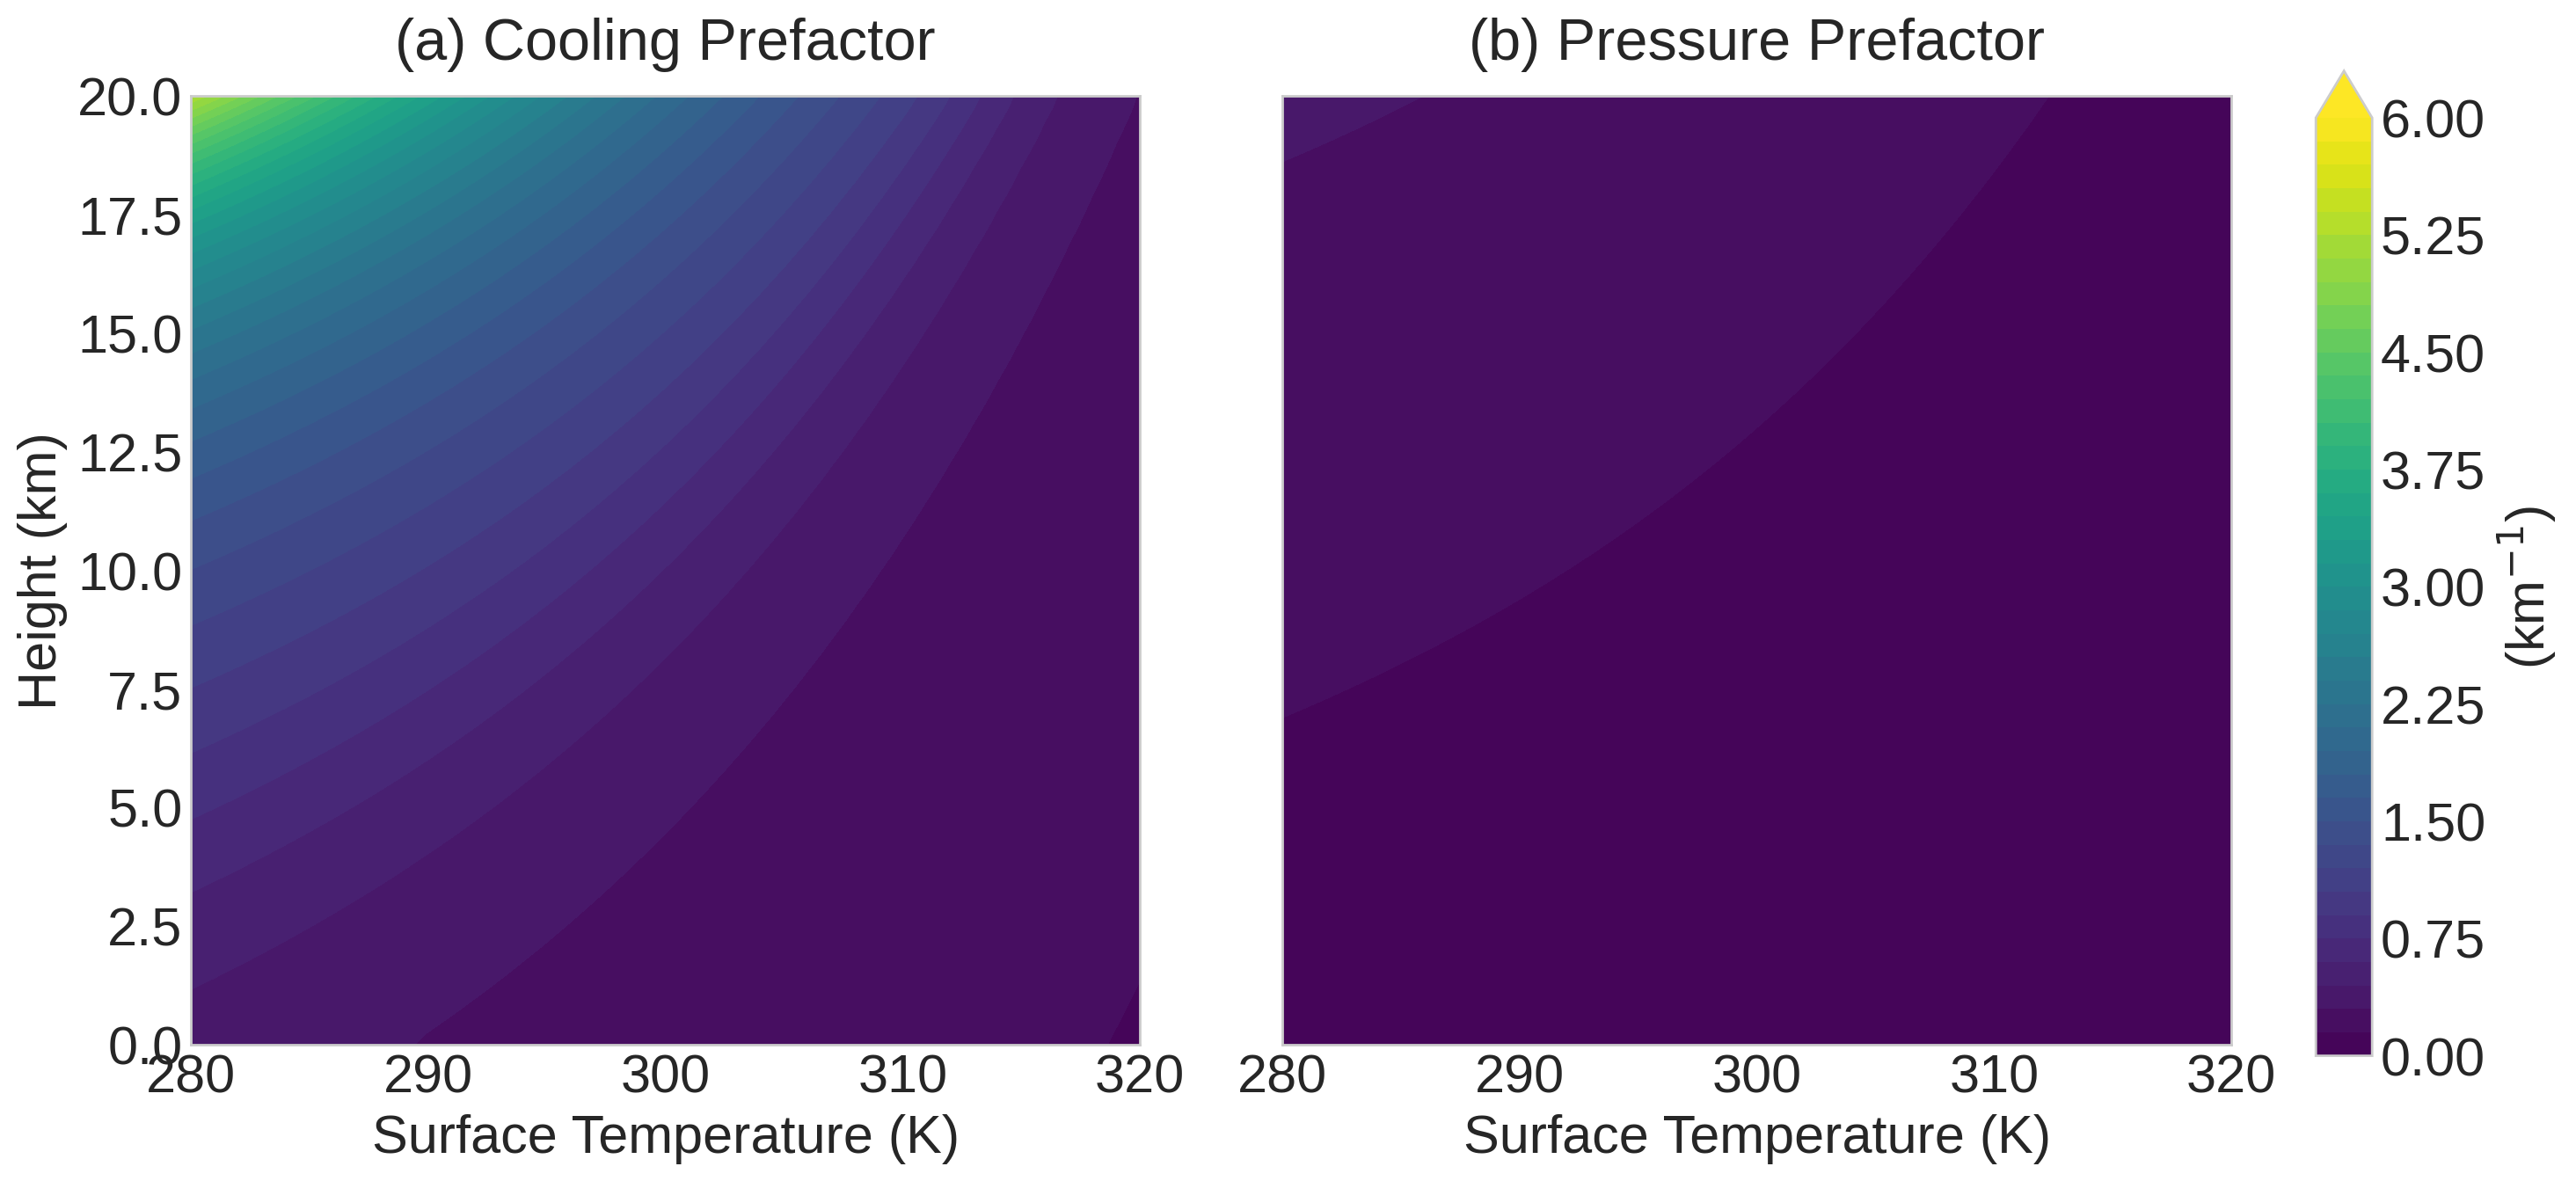

Figure 4 saved as figure_4_prefactor_scaling.png


In [2]:
# ==============================================================================
# SCRIPT TO CREATE FIGURE 4:
# SCALING ANALYSIS OF SENSITIVITY PREFACTORS
#
# This script creates a two-panel figure to visually support the scaling
# argument presented in the manuscript's derivation. It demonstrates why the
# Pressure Term's influence on lapse rate sensitivity grows more rapidly with
# background temperature than the Cooling Term's influence.
#
# The script plots the two key "prefactors" that modulate the exponentially
# increasing saturation specific humidity (qs).
#
# The script performs the following actions:
# 1. Defines the same thermodynamic constants and functions as the previous
#    figure for consistency.
# 2. Implements a function to calculate the "Cooling Prefactor" and "Pressure
#    Prefactor" along moist adiabatic temperature profiles.
# 3. For a range of surface temperatures (Ts), it computes profiles
#    of these prefactors.
# 4. It interpolates these profiles onto a regular grid of height and Ts.
# 5. Finally, it generates a two-panel filled contour plot showing:
#    (a) The Cooling Prefactor: Gamma_m * L_v / (R_v * T^2)
#    (b) The Pressure Prefactor: g / (R_d * T_v)
# ==============================================================================

# For sharper inline plots in Jupyter environments
try:
    get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")
except (NameError, AttributeError):
    pass

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy import constants
from scipy.interpolate import interp1d
import time

# --- Physical Constants ---
g = constants.g
cpd = 1005.7
Rd = 287.05
Rv = 461.5
epsilon = Rd / Rv
Lv_const = 2.501e6

# --- Core Thermodynamic & Profile Functions ---

def saturation_vapor_pressure(T):
    """Calculates saturation vapor pressure (es) in Pa."""
    T_celsius = T - 273.15
    es_hPa = 6.112 * np.exp((17.67 * T_celsius) / (T_celsius + 243.5))
    return es_hPa * 100.0

def saturation_specific_humidity(p, T):
    """Calculates saturation specific humidity (qs) in kg/kg."""
    es = saturation_vapor_pressure(T)
    es = np.minimum(es, p * 0.99)
    denominator = p - (1.0 - epsilon) * es
    denominator = np.maximum(denominator, 1e-3)
    qs = epsilon * es / denominator
    return np.maximum(qs, 0.0)

def virtual_temperature(T, p):
    """Calculates virtual temperature (Tv) in K."""
    qs = saturation_specific_humidity(p, T)
    return T * (1.0 + (1.0 / epsilon - 1.0) * qs)

def calculate_mse(T, p, z):
    """Calculates Moist Static Energy (MSE) in J/kg."""
    qs = saturation_specific_humidity(p, T)
    return cpd * T + g * z + Lv_const * qs

def moist_lapse_rate_from_profile(T, z):
    """Calculates Gamma_m from a temperature profile via finite difference."""
    dz = z[1] - z[0]
    return -np.gradient(T, dz)

def calculate_moist_adiabatic_profile(T_surf, p_surf, z_max, dz):
    """Calculates z, T, and p profiles by conserving MSE."""
    n_steps = int(z_max / dz) + 1
    z_profile = np.linspace(0, z_max, n_steps)
    T_profile, p_profile = np.full(n_steps, np.nan), np.full(n_steps, np.nan)
    T_profile[0], p_profile[0] = T_surf, p_surf
    mse_conserved = calculate_mse(T_profile[0], p_profile[0], 0.0)
    for i in range(n_steps - 1):
        z_c, T_c, p_c = z_profile[i], T_profile[i], p_profile[i]
        if np.isnan(T_c) or p_c <= 0: break
        z_n = z_profile[i+1]
        Tv_c = virtual_temperature(T_c, p_c)
        H = (Rd * Tv_c) / g
        p_n = p_c * np.exp(-dz / H)
        if p_n <= 0: break
        def res(T_g): return calculate_mse(T_g, p_n, z_n) - mse_conserved
        try:
            sol = root_scalar(res, bracket=[50.0, T_c + 5], method='brentq')
            if sol.converged: T_profile[i+1], p_profile[i+1] = sol.root, p_n
            else: break
        except (ValueError, RuntimeError): break
    valid = ~np.isnan(T_profile)
    return z_profile[valid], T_profile[valid], p_profile[valid]

def get_prefactor_profiles(t_surf_k, p_surf_pa, z_max, dz):
    """
    Calculates the cooling and pressure prefactors for the scaling argument.
    """
    z_profile, t_profile, p_profile = calculate_moist_adiabatic_profile(
        t_surf_k, p_surf_pa, z_max, dz
    )

    if len(z_profile) < 2:
        return z_profile, None, None

    # Calculate necessary profiles for prefactor calculation
    gamma_m_profile = moist_lapse_rate_from_profile(t_profile, z_profile)
    tv_profile = virtual_temperature(t_profile, p_profile)

    # Calculate prefactor profiles
    # Unit: (K/m) * (J/kg) / (J/(kg*K) * K^2) = 1/m
    cooling_prefactor = gamma_m_profile * Lv_const / (Rv * t_profile**2)

    # Unit: (m/s^2) / (J/(kg*K) * K) = (m/s^2) / (m^2/(s^2*K) * K) = 1/m
    pressure_prefactor = g / (Rd * tv_profile)

    return z_profile, cooling_prefactor, pressure_prefactor

def main():
    """Main function to execute the calculation and plotting."""
    print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Starting prefactor contour plot generation...")

    # --- Parameters ---
    P_SURFACE_PA = 100000.0
    Z_MAX_M = 20100
    DZ_M = 250
    T_surf_range_K = np.arange(280, 320.1, 1.0)
    z_grid_km = np.arange(0, Z_MAX_M / 1000, DZ_M / 1000)

    # Initialize 2D arrays for the grids
    cooling_prefactor_grid = np.full((len(z_grid_km), len(T_surf_range_K)), np.nan)
    pressure_prefactor_grid = np.full((len(z_grid_km), len(T_surf_range_K)), np.nan)

    # --- Calculation Loop ---
    for i, t_surf_k in enumerate(T_surf_range_K):
        print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Processing Ts = {t_surf_k:.1f} K...")
        z, cooling_pf, pressure_pf = get_prefactor_profiles(
            t_surf_k, P_SURFACE_PA, Z_MAX_M, DZ_M
        )
        if len(z) > 1:
            # Interpolate onto the common grid
            interp_z_m = z_grid_km * 1000
            cooling_prefactor_grid[:, i] = interp1d(z, cooling_pf, bounds_error=False, fill_value=np.nan)(interp_z_m)
            pressure_prefactor_grid[:, i] = interp1d(z, pressure_pf, bounds_error=False, fill_value=np.nan)(interp_z_m)

    # Convert units from 1/m to 1/km
    cooling_prefactor_grid_plot = cooling_prefactor_grid * 1000
    pressure_prefactor_grid_plot = pressure_prefactor_grid * 1000

    # --- Visualization ---
    print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Calculation complete. Generating plot...")

    T_grid_K, Z_grid_km = np.meshgrid(T_surf_range_K, z_grid_km)
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
    base_fontsize = 22

    plot_data = [
        {'grid': cooling_prefactor_grid_plot, 'title': '(a) Cooling Prefactor'},
        {'grid': pressure_prefactor_grid_plot, 'title': '(b) Pressure Prefactor'}
    ]

    # Use a single sequential colormap as prefactors are always positive
    cmap = plt.get_cmap('viridis')

    # Find common color limits for both plots to facilitate comparison
    max_val = np.nanmax([plot_data[0]['grid'], plot_data[1]['grid']])
    levels = np.linspace(0, np.ceil(max_val), 41)

    # Panel A: Cooling Prefactor
    contour1 = axes[0].contourf(T_grid_K, Z_grid_km, plot_data[0]['grid'], levels=levels, cmap=cmap, extend='max')

    # Panel B: Pressure Prefactor
    contour2 = axes[1].contourf(T_grid_K, Z_grid_km, plot_data[1]['grid'], levels=levels, cmap=cmap, extend='max')

    for i, ax in enumerate(axes):
        ax.set_title(plot_data[i]['title'], fontsize=base_fontsize + 2, pad=15)
        ax.set_xlabel('Surface Temperature (K)', fontsize=base_fontsize)
        ax.tick_params(axis='both', which='major', labelsize=base_fontsize)
        ax.set_ylim(0, 20)
        ax.set_box_aspect(1) # Make axes square

    axes[0].set_ylabel('Height (km)', fontsize=base_fontsize)

    # Add a shared colorbar
    fig.subplots_adjust(right=0.85, wspace=0.15)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(contour1, cax=cbar_ax)
    cbar.set_label('(km$^{-1}$)', fontsize=base_fontsize)
    cbar.ax.tick_params(labelsize=base_fontsize)

    fig4_filename = "fig-4.png"
    plt.savefig(fig4_filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Figure 4 saved as {fig4_filename}")


if __name__ == '__main__':
    main()
